In [1]:
import numpy as np

from statespace.models import NVMLangevinModel
from statespace.models import NVMConstantVelocityModel

from stochastic.processes import GammaProcess
from stochastic.processes import TemperedStableProcess
from stochastic.processes import GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, SequentialCollapsedGaussianMCMCFilter

import pandas as pd
import matplotlib.pyplot as plt

# Langevin model example:

## Generate data:

In [2]:
T = np.linspace(0, 10, num=50).reshape(-1, 1)

In [3]:
gamma_process_params = {"beta":1., "C":1.}
# subordinator = GammaProcess(**gamma_process_params)

tempered_stable_process_params = {"alpha":0.6, "beta":0.1, "C":0.5}
# subordinator = TemperedStableProcess(**tempered_stable_process_params)

gig_process_params = {"lam":-0.8, "gamma":0.01, "delta":1.0}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

# # student t process:
# lam = -2.5
# delta = np.sqrt(-2 * lam)

# gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
# subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
An independent gamma process extension will be made.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [4]:
mu = 0.
theta = -0.2
sigma = 1.0
sigma_eps = 0.1

n_particles = 1

langevin_model = NVMLangevinModel(subordinator=subordinator, theta=theta, mu=mu, sigma=sigma, sigma_eps=sigma_eps, shape=(2,1), n_particles=n_particles)

In [5]:
x, y = langevin_model.sample(times=T, size=n_particles)

/Users/yaman/models/stochastic/processes.py:738: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)
/Users/yaman/models/stochastic/processes.py:743: RuntimeWarning: divide by zero encountered in divide
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:743: RuntimeWarning: invalid value encountered in multiply
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:772: RuntimeWarning: divide by zero encountered in divide
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(0.5, u_z*(gammaincc(0.5, (z1**2)*x_series/(2*self.delta**2)))


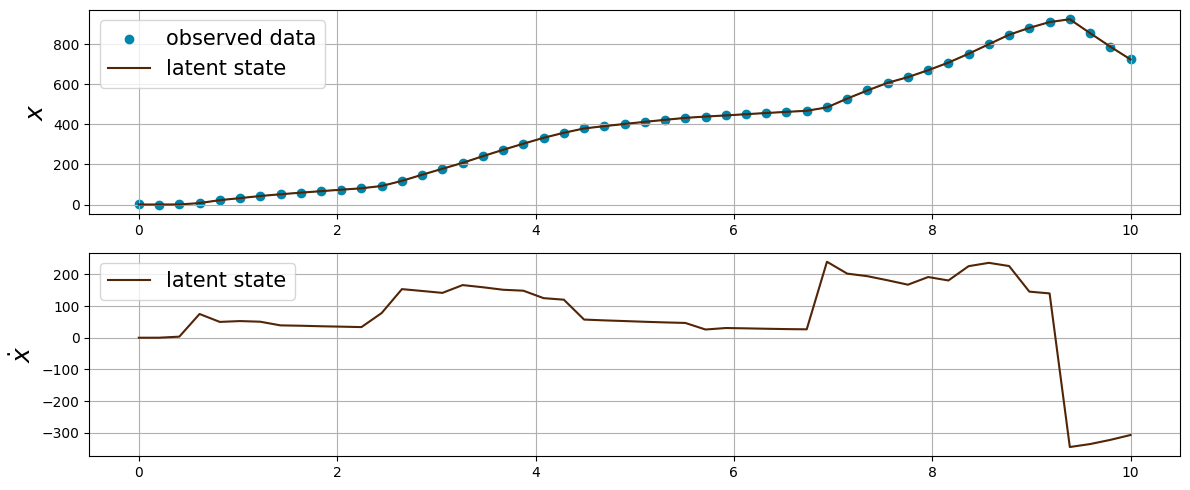

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=y.shape[0], figsize=(12,5))

try:

    for i in range(y.shape[0]):
        # Plot observations:
        ax[0][i].scatter(T, y[i, :,0,:], color="#0085ad", label="observed data")
        ax[0][i].plot(T, y[i, :,0,:], color="#0085ad", lw=0.8)

        # Plot state:
        ax[0][i].plot(T, x[i, :,0,:], color="#522506", label="latent state")
        ax[0][i].legend(fontsize=15)
        ax[0][i].set_ylabel(r"$x$", fontsize=18)
        ax[0][i].grid(True)

        # Plot velocity state:
        ax[1][i].plot(T, x[i, :,1,:], color="#522506", label="latent state")
        ax[1][i].legend(fontsize=15)
        ax[1][i].set_ylabel(r"$\dot{x}$", fontsize=18)
        ax[1][i].grid(True)

except:

    # Plot observations:
    ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
    ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

    # Plot state:
    ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")
    ax[0].legend(fontsize=15)
    ax[0].set_ylabel(r"$x$", fontsize=18)
    ax[0].grid(True)

    # Plot velocity state:
    ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")
    ax[1].legend(fontsize=15)
    ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
    ax[1].grid(True)

plt.tight_layout()
plt.show()

In [7]:
langevin_model.get_parameter_values()

{'theta': -0.2, 'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

## Kalman filtering with true subordinator jumps:

In [8]:
inference_method = KalmanFilter(model=langevin_model, prior=None, proposal=None)

The prior configuration is not valid.


In [9]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(langevin_model.n_particles, x[0].shape[-2], 1))

P_init = np.random.normal(loc=0., scale=1., size=(langevin_model.n_particles, x[0].shape[-2], x[0].shape[-2]))
P_init = np.transpose(P_init, axes=[0, 2, 1]) @ P_init

In [10]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

In [11]:
x_est = inference_method.x_est
P_est = inference_method.P_est

#vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
vars = []
for _ in range(P_est.shape[0]):
    vars.append(np.array([np.diag(COV) for COV in P_est[_, 1:,:,:]]))
vars = np.array(vars)

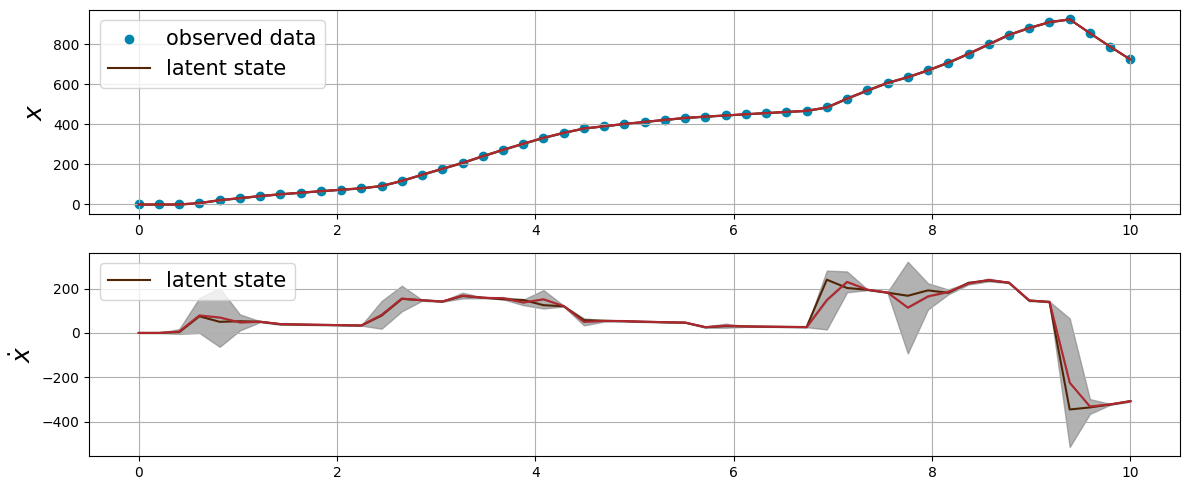

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=y.shape[0], figsize=(12,5))

try:

    for i in range(y.shape[0]):
        # Plot observations:
        ax[0][i].scatter(T, y[i, :,0,:], color="#0085ad", label="observed data")
        ax[0][i].plot(T, y[i, :,0,:], color="#0085ad", lw=0.8)

        # Plot state:
        ax[0][i].plot(T, x[i, :,0,:], color="#522506", label="latent state")
        ax[0][i].legend(fontsize=15)
        ax[0][i].set_ylabel(r"$x$", fontsize=18)
        ax[0][i].grid(True)

        # Plot state estimate:
        ax[0][i].plot(T, x_est[i, 1:,0,:], color="#AF272F", label="latent state estimate")
        ax[0][i].fill_between(T.flatten(), x_est[i, 1:,0,:].flatten(), x_est[i, 1:,0,:].flatten() + 3 * np.sqrt(vars[i, :, 0]), color='grey', alpha=0.6)
        ax[0][i].fill_between(T.flatten(), x_est[i, 1:,0,:].flatten(), x_est[i, 1:,0,:].flatten() - 3 * np.sqrt(vars[i, :, 0]), color='grey', alpha=0.6)

        # Plot velocity state:
        ax[1][i].plot(T, x[i, :,1,:], color="#522506", label="latent state")
        ax[1][i].legend(fontsize=15)
        ax[1][i].set_ylabel(r"$\dot{x}$", fontsize=18)
        ax[1][i].grid(True)

        # Plot velocity state estimate:
        ax[1][i].plot(T, x_est[i, 1:,1,:], color="#AF272F", label="latent state estimate")
        ax[1][i].fill_between(T.flatten(), x_est[i, 1:,1,:].flatten(), x_est[i, 1:,1,:].flatten() + 3 * np.sqrt(vars[i, :, 1]), color='grey', alpha=0.6)
        ax[1][i].fill_between(T.flatten(), x_est[i, 1:,1,:].flatten(), x_est[i, 1:,1,:].flatten() - 3 * np.sqrt(vars[i, :, 1]), color='grey', alpha=0.6)

except:

    # Plot observations:
    ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
    ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

    # Plot state:
    ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")
    ax[0].legend(fontsize=15)
    ax[0].set_ylabel(r"$x$", fontsize=18)
    ax[0].grid(True)

    # Plot state estimate:
    ax[0].plot(T, x_est[i, 1:,0,:], color="#AF272F", label="latent state estimate")
    ax[0].fill_between(T.flatten(), x_est[0, 1:,0,:].flatten(), x_est[0, 1:,0,:].flatten() + 3 * np.sqrt(vars[0, :, 0]), color='grey', alpha=0.6)
    ax[0].fill_between(T.flatten(), x_est[0, 1:,0,:].flatten(), x_est[0, 1:,0,:].flatten() - 3 * np.sqrt(vars[0, :, 0]), color='grey', alpha=0.6)

    # Plot velocity state:
    ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")
    ax[1].legend(fontsize=15)
    ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
    ax[1].grid(True)

    # Plot velocity state estimate:
    ax[1].plot(T, x_est[i, 1:,1,:], color="#AF272F", label="latent state estimate")
    ax[1].fill_between(T.flatten(), x_est[0, 1:,1,:].flatten(), x_est[0, 1:,1,:].flatten() + 3 * np.sqrt(vars[0, :, 1]), color='grey', alpha=0.6)
    ax[1].fill_between(T.flatten(), x_est[0, 1:,1,:].flatten(), x_est[0, 1:,1,:].flatten() - 3 * np.sqrt(vars[0, :, 1]), color='grey', alpha=0.6)

plt.tight_layout()
plt.show()

## Sequential Marginalised Metropolis-Hastings Filter:

In [13]:
subordinator_inference = GeneralisedInverseGaussianProcess(**gig_process_params)
# subordinator_inference = GammaProcess(**gamma_process_params)
# subordinator_inference = TemperedStableProcess(**tempered_stable_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
An independent gamma process extension will be made.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [14]:
n_particles = 1
langevin_model_inference = NVMLangevinModel(subordinator=subordinator_inference, theta=theta, mu=mu, sigma=sigma, sigma_eps=sigma_eps, shape=(2,1), n_particles=n_particles)

In [15]:
inference_method_inference = SequentialCollapsedGaussianMCMCFilter(model=langevin_model_inference, prior=None, proposal=None)

The prior configuration is not valid.


In [16]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(langevin_model_inference.n_particles, x[0].shape[-2], 1))

P_init = np.random.normal(loc=0., scale=1., size=(langevin_model_inference.n_particles, x[0].shape[-2], x[0].shape[-2]))
P_init = np.transpose(P_init, axes=[0, 2, 1]) @ P_init

In [17]:
history = inference_method_inference.filter(times=T, y=y[0][np.newaxis], x_init=x_init, P_init=P_init, n_samples=50, burn_in=30)

/Users/yaman/models/stochastic/processes.py:753: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)
/Users/yaman/models/stochastic/processes.py:758: RuntimeWarning: divide by zero encountered in divide
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:758: RuntimeWarning: invalid value encountered in multiply
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:38: RuntimeWarning: overflow encountered in exp
  return 1/(self.beta*(np.exp(gamma/self.C)-1))
/Users/yaman/models/statespace/methods.py:267: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(proposed_lo

In [18]:
inference_method_inference.model.I.subordinator.t_series.shape

(1, 48951)

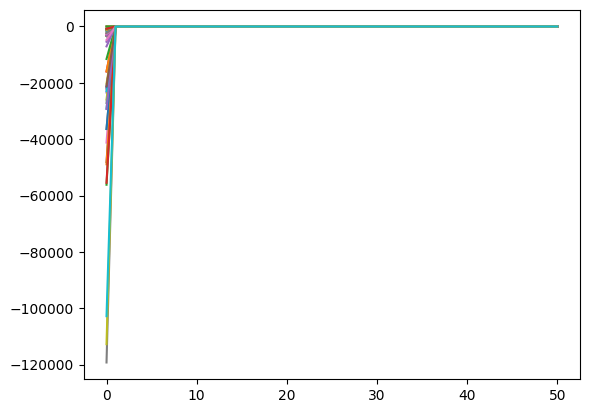

In [19]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots()

ax.plot(np.array(inference_method_inference.log_evidence)[:,:,0,0,0].T)

#ax.plot(np.log(np.array(inference_method_inference.log_evidence)[:,:,0,0].T - np.array(inference_method_inference.log_evidence)[:,:,0,0].T.min()))

plt.show()

In [20]:
post_means = inference_method_inference.x_est[0][1:]
post_vars = np.array([np.diag(COV) for COV in inference_method_inference.P_est[0][1:]])

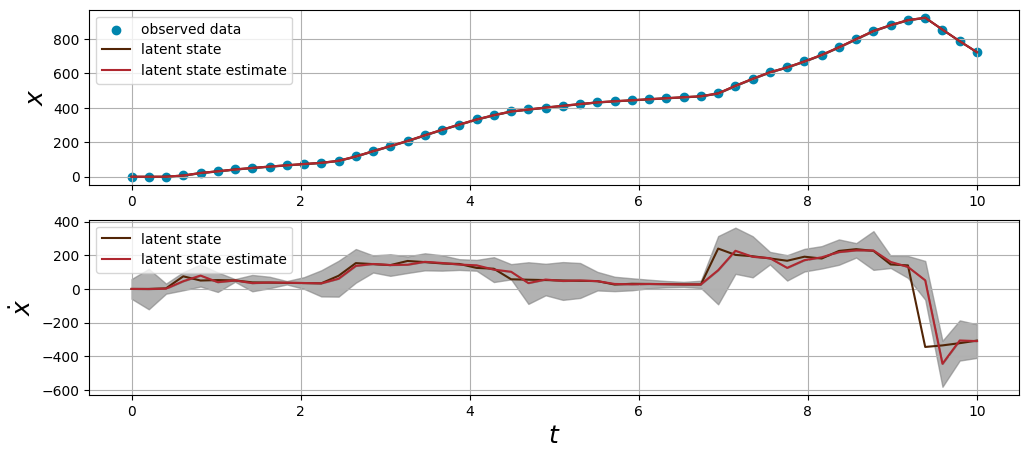

In [21]:
fig, ax = plt.subplots(nrows=2, figsize=(12,5))

# Plot observations:
ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, post_means[:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)

#ax[0].set_ybound(-0.05, 0.25)

# Settings:
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, post_means[:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

#ax[1].set_ybound(-100, 200)

# Settings:
ax[1].legend(fontsize=10)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].grid(True)

#plt.savefig("example4.jpg", dpi=200)
plt.show()

# Constant velocity model:

## Generate data:

In [49]:
T = np.linspace(0, 100, num=200).reshape(-1, 1)

In [50]:
gamma_process_params = {"beta":1., "C":1.}
# subordinator = GammaProcess(**gamma_process_params)

tempered_stable_process_params = {"alpha":0.3, "beta":0.1, "C":0.5}
subordinator = TemperedStableProcess(**tempered_stable_process_params)

gig_process_params = {"lam":-0.4, "gamma":0.01, "delta":1.0}
# subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.


In [51]:
n_particles = 1

constant_velocity_model = NVMConstantVelocityModel(subordinator=subordinator, mu=0., sigma=1., sigma_eps=0.1, shape=(2,1))

In [52]:
x, y = constant_velocity_model.sample(times=T, size=n_particles)

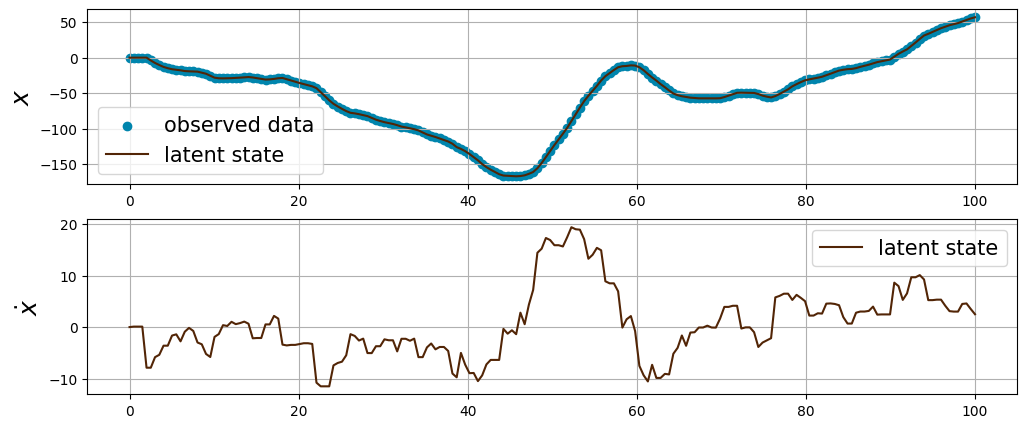

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=y.shape[0], figsize=(12,5))

try:

    for i in range(y.shape[0]):
        # Plot observations:
        ax[0][i].scatter(T, y[i, :,0,:], color="#0085ad", label="observed data")
        ax[0][i].plot(T, y[i, :,0,:], color="#0085ad", lw=0.8)

        # Plot state:
        ax[0][i].plot(T, x[i, :,0,:], color="#522506", label="latent state")
        ax[0][i].legend(fontsize=15)
        ax[0][i].set_ylabel(r"$x$", fontsize=18)
        ax[0][i].grid(True)

        # Plot velocity state:
        ax[1][i].plot(T, x[i, :,1,:], color="#522506", label="latent state")
        ax[1][i].legend(fontsize=15)
        ax[1][i].set_ylabel(r"$\dot{x}$", fontsize=18)
        ax[1][i].grid(True)

except:

    # Plot observations:
    ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
    ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

    # Plot state:
    ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")
    ax[0].legend(fontsize=15)
    ax[0].set_ylabel(r"$x$", fontsize=18)
    ax[0].grid(True)

    # Plot velocity state:
    ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")
    ax[1].legend(fontsize=15)
    ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
    ax[1].grid(True)

plt.show()

In [54]:
constant_velocity_model.get_parameter_values()

{'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

## Kalman filtering with true subordinator jumps:

In [55]:
inference_method = KalmanFilter(model=constant_velocity_model, prior=None, proposal=None)

The prior configuration is not valid.


In [56]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(constant_velocity_model.n_particles, x[0].shape[-2], 1))

P_init = np.random.normal(loc=0., scale=1., size=(constant_velocity_model.n_particles, x[0].shape[-2], x[0].shape[-2]))
P_init = np.transpose(P_init, axes=[0, 2, 1]) @ P_init

In [57]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

In [58]:
x_est = inference_method.x_est
P_est = inference_method.P_est

#vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
vars = []
for _ in range(P_est.shape[0]):
    vars.append(np.array([np.diag(COV) for COV in P_est[_, 1:,:,:]]))
vars = np.array(vars)

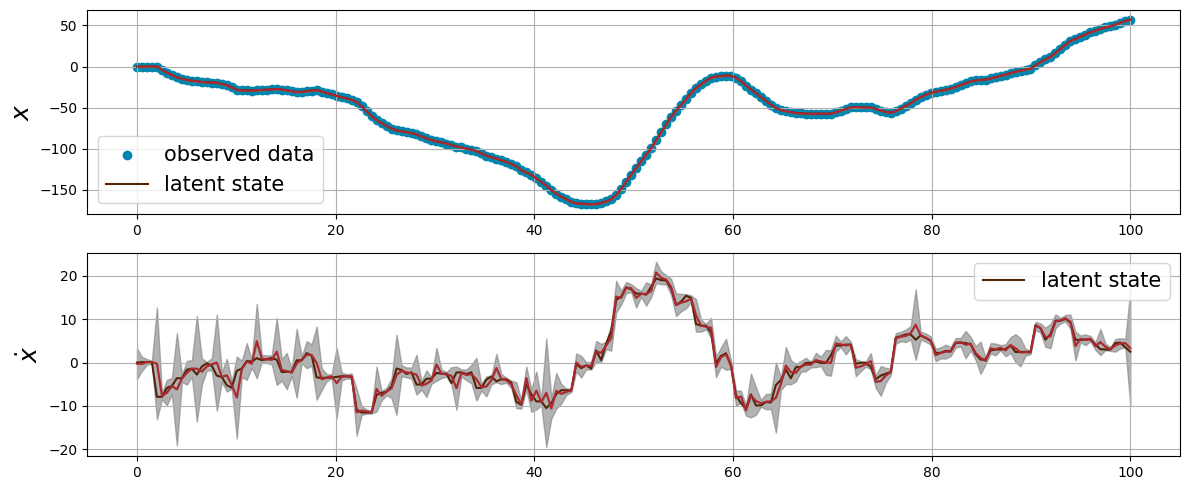

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=y.shape[0], figsize=(12,5))

try:

    for i in range(y.shape[0]):
        # Plot observations:
        ax[0][i].scatter(T, y[i, :,0,:], color="#0085ad", label="observed data")
        ax[0][i].plot(T, y[i, :,0,:], color="#0085ad", lw=0.8)

        # Plot state:
        ax[0][i].plot(T, x[i, :,0,:], color="#522506", label="latent state")
        ax[0][i].legend(fontsize=15)
        ax[0][i].set_ylabel(r"$x$", fontsize=18)
        ax[0][i].grid(True)

        # Plot state estimate:
        ax[0][i].plot(T, x_est[i, 1:,0,:], color="#AF272F", label="latent state estimate")
        ax[0][i].fill_between(T.flatten(), x_est[i, 1:,0,:].flatten(), x_est[i, 1:,0,:].flatten() + 3 * np.sqrt(vars[i, :, 0]), color='grey', alpha=0.6)
        ax[0][i].fill_between(T.flatten(), x_est[i, 1:,0,:].flatten(), x_est[i, 1:,0,:].flatten() - 3 * np.sqrt(vars[i, :, 0]), color='grey', alpha=0.6)

        # Plot velocity state:
        ax[1][i].plot(T, x[i, :,1,:], color="#522506", label="latent state")
        ax[1][i].legend(fontsize=15)
        ax[1][i].set_ylabel(r"$\dot{x}$", fontsize=18)
        ax[1][i].grid(True)

        # Plot velocity state estimate:
        ax[1][i].plot(T, x_est[i, 1:,1,:], color="#AF272F", label="latent state estimate")
        ax[1][i].fill_between(T.flatten(), x_est[i, 1:,1,:].flatten(), x_est[i, 1:,1,:].flatten() + 3 * np.sqrt(vars[i, :, 1]), color='grey', alpha=0.6)
        ax[1][i].fill_between(T.flatten(), x_est[i, 1:,1,:].flatten(), x_est[i, 1:,1,:].flatten() - 3 * np.sqrt(vars[i, :, 1]), color='grey', alpha=0.6)

except:

    # Plot observations:
    ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
    ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

    # Plot state:
    ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")
    ax[0].legend(fontsize=15)
    ax[0].set_ylabel(r"$x$", fontsize=18)
    ax[0].grid(True)

    # Plot state estimate:
    ax[0].plot(T, x_est[i, 1:,0,:], color="#AF272F", label="latent state estimate")
    ax[0].fill_between(T.flatten(), x_est[0, 1:,0,:].flatten(), x_est[0, 1:,0,:].flatten() + 3 * np.sqrt(vars[0, :, 0]), color='grey', alpha=0.6)
    ax[0].fill_between(T.flatten(), x_est[0, 1:,0,:].flatten(), x_est[0, 1:,0,:].flatten() - 3 * np.sqrt(vars[0, :, 0]), color='grey', alpha=0.6)

    # Plot velocity state:
    ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")
    ax[1].legend(fontsize=15)
    ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
    ax[1].grid(True)

    # Plot velocity state estimate:
    ax[1].plot(T, x_est[i, 1:,1,:], color="#AF272F", label="latent state estimate")
    ax[1].fill_between(T.flatten(), x_est[0, 1:,1,:].flatten(), x_est[0, 1:,1,:].flatten() + 3 * np.sqrt(vars[0, :, 1]), color='grey', alpha=0.6)
    ax[1].fill_between(T.flatten(), x_est[0, 1:,1,:].flatten(), x_est[0, 1:,1,:].flatten() - 3 * np.sqrt(vars[0, :, 1]), color='grey', alpha=0.6)

plt.tight_layout()
plt.show()

## Sequential Marginalised Metropolis-Hastings Filter:

In [60]:
#subordinator_inference = GeneralisedInverseGaussianProcess(**gig_process_params)
# subordinator_inference = GammaProcess(**gamma_process_params)
subordinator_inference = TemperedStableProcess(**tempered_stable_process_params)

Residual approximation mode is set to Gaussian approximation.


In [61]:
n_particles = 1
constant_velocity_model_inference = NVMConstantVelocityModel(subordinator=subordinator_inference, mu=0., sigma=1., sigma_eps=0.1, shape=(2,1), n_particles=n_particles)

In [62]:
inference_method_inference = SequentialCollapsedGaussianMCMCFilter(model=constant_velocity_model_inference, prior=None, proposal=None)

The prior configuration is not valid.


In [63]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=(constant_velocity_model_inference.n_particles, x[0].shape[-2], 1))

P_init = np.random.normal(loc=0., scale=1., size=(constant_velocity_model_inference.n_particles, x[0].shape[-2], x[0].shape[-2]))
P_init = np.transpose(P_init, axes=[0, 2, 1]) @ P_init

In [64]:
history = inference_method_inference.filter(times=T, y=y[0][np.newaxis], x_init=x_init, P_init=P_init, n_samples=100, burn_in=30)

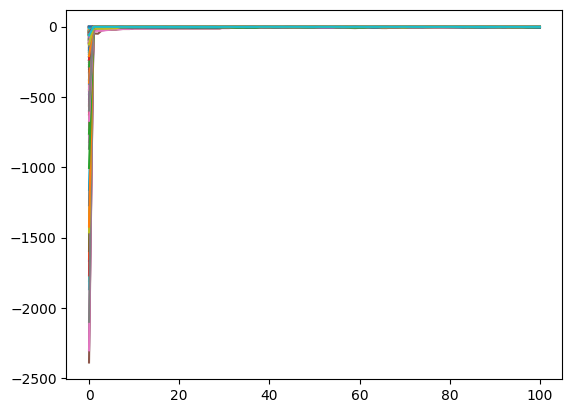

In [65]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots()

ax.plot(np.array(inference_method_inference.log_evidence)[:,:,0,0,0].T)

#ax.plot(np.log(np.array(inference_method_inference.log_evidence)[:,:,0,0].T - np.array(inference_method_inference.log_evidence)[:,:,0,0].T.min()))

plt.show()

In [66]:
post_means = inference_method_inference.x_est[0][1:]
post_vars = np.array([np.diag(COV) for COV in inference_method_inference.P_est[0][1:]])

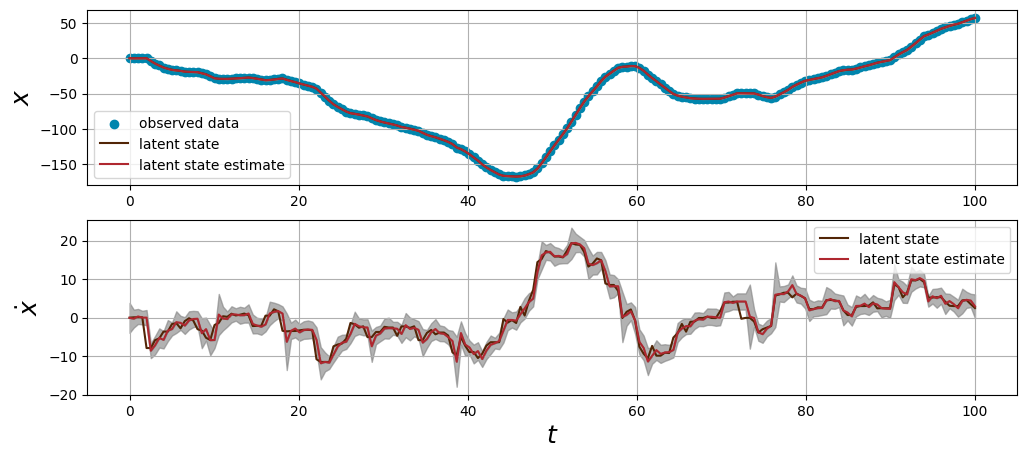

In [67]:
fig, ax = plt.subplots(nrows=2, figsize=(12,5))

# Plot observations:
ax[0].scatter(T, y[0, :,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[0, :,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, post_means[:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(T.flatten(), post_means[:,0,:].flatten(), post_means[:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)

#ax[0].set_ybound(-0.05, 0.25)

# Settings:
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, post_means[:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), post_means[:,1,:].flatten(), post_means[:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

#ax[1].set_ybound(-100, 200)

# Settings:
ax[1].legend(fontsize=10)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].grid(True)

#plt.savefig("example4.jpg", dpi=200)
plt.show()